# CNN-bi-LSTM for Speech Recognition

This notebook implements a CNN-bi-LSTM neural network for speech recognition using the LJ-Speech dataset. The model converts speech to text using a combination of convolutional neural networks (CNN) and bidirectional long short-term memory (LSTM) networks.


In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from flatbuffers.packer import float32
from numpy import dtype
from tensorflow import keras
from tensorflow.keras import layers
import wave
import glob
from IPython.display import Audio
from sklearn.model_selection import train_test_split


## 1. Data Loading and Exploration

First, let's load the metadata and explore the dataset.


In [2]:
# Path to the dataset
data_path = "data/LJSpeech-1.1/"
wavs_path = os.path.join(data_path, "wavs/")
metadata_path = os.path.join(data_path, "metadata.csv")

# Load metadata
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_id", "transcription", "normalized_transcription"]
metadata_df["wav_file"] = metadata_df["file_id"].apply(lambda x: os.path.join(wavs_path, f"{x}.wav"))

# Display the first few rows
metadata_df.head()


,file_id,transcription,normalized_transcription,wav_file
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ...",data/LJSpeech-1.1/wavs/LJ001-0001.wav
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.,data/LJSpeech-1.1/wavs/LJ001-0002.wav
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...,data/LJSpeech-1.1/wavs/LJ001-0003.wav
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed...",data/LJSpeech-1.1/wavs/LJ001-0004.wav
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...,data/LJSpeech-1.1/wavs/LJ001-0005.wav


In [3]:
# Check the number of samples
print(f"Total number of samples: {len(metadata_df)}")

# Check if all wav files exist
missing_files = [f for f in metadata_df["wav_file"] if not os.path.exists(f)]
print(f"Number of missing wav files: {len(missing_files)}")

# Get some statistics about the transcriptions
metadata_df["transcription_length"] = metadata_df["transcription"].apply(len)
print(f"Average transcription length: {metadata_df['transcription_length'].mean():.2f} characters")
print(f"Min transcription length: {metadata_df['transcription_length'].min()} characters")
print(f"Max transcription length: {metadata_df['transcription_length'].max()} characters")


Total number of samples: 13100
Number of missing wav files: 0
Average transcription length: 98.35 characters
Min transcription length: 5 characters
Max transcription length: 187 characters


## 2. Audio Preprocessing

Now, let's implement functions to load and preprocess the audio files. We'll convert the audio to spectrograms, which will be the input to our neural network.


In [4]:
# Function to read a wav file and return the audio data
def read_wav_file(wav_file):
    with wave.open(wav_file, "rb") as wav:
        # Get basic information about the wav file
        n_channels = wav.getnchannels()
        sample_width = wav.getsampwidth()
        frame_rate = wav.getframerate()
        n_frames = wav.getnframes()

        # Read the audio data
        audio_data = wav.readframes(n_frames)

        # Convert to numpy array
        audio_data = np.frombuffer(audio_data, dtype=np.int16)

        # Normalize to [-1, 1]
        audio_data = audio_data.astype(np.float32) / 32768.0

    return audio_data, frame_rate


In [5]:
# Function to compute spectrogram from audio data
def compute_spectrogram(audio_data, frame_rate, frame_length=256, frame_step=160, fft_length=384):
    # Compute the Short-Time Fourier Transform (STFT)
    stft = tf.signal.stft(
        audio_data,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length,
        window_fn=tf.signal.hann_window
    )

    # Compute the magnitude spectrogram
    spectrogram = tf.abs(stft)

    # Apply the mel filterbank
    num_mel_bins = 80
    lower_edge_hertz = 80.0
    upper_edge_hertz = 7600.0

    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, spectrogram.shape[-1], frame_rate, lower_edge_hertz, upper_edge_hertz
    )

    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)

    # Convert to log scale (dB)
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    return log_mel_spectrogram


2025-05-21 09:21:25.285942: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-05-21 09:21:25.285971: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-21 09:21:25.285975: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-05-21 09:21:25.285991: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-21 09:21:25.286002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


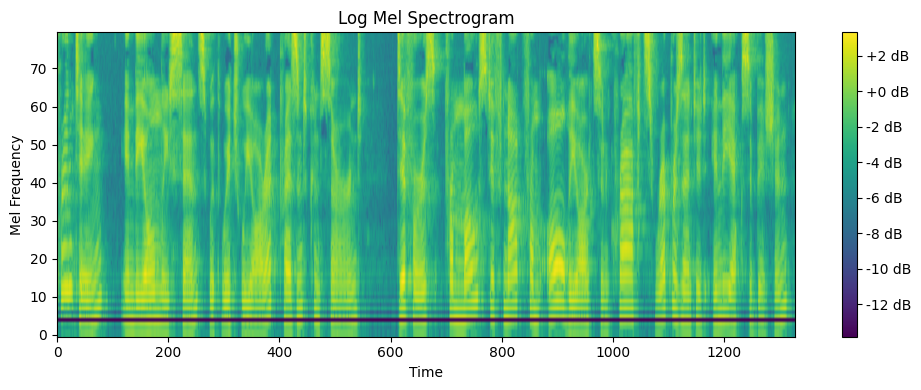

In [6]:
# Let's visualize a spectrogram for one audio file
sample_wav_file = metadata_df["wav_file"].iloc[0]
sample_audio_data, sample_frame_rate = read_wav_file(sample_wav_file)
sample_spectrogram = compute_spectrogram(sample_audio_data, sample_frame_rate)

plt.figure(figsize=(10, 4))
plt.imshow(tf.transpose(sample_spectrogram), aspect="auto", origin="lower")
plt.colorbar(format="%+2.0f dB")
plt.title("Log Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.tight_layout()
plt.show()

# Play the audio
Audio(sample_audio_data, rate=sample_frame_rate)


## 3. Text Preprocessing

Next, let's preprocess the text data. We'll create a character-level tokenizer to convert text to sequences of integers.


In [7]:
# Create a vocabulary of characters
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(f"The vocabulary is: {char_to_num.get_vocabulary()} (size: {len(char_to_num.get_vocabulary())})")


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size: 31)


In [8]:
# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters except those in our vocabulary
    text = "".join([c for c in text if c in characters])

    # Convert to sequence of integers
    text_encoded = char_to_num(tf.strings.unicode_split(text, input_encoding="UTF-8"))

    return text_encoded


In [9]:
# Test the text preprocessing
sample_text = metadata_df["transcription"].iloc[0]
print(f"Original text: {sample_text}")
processed_text = preprocess_text(sample_text)
print(f"Processed text: {processed_text}")
decoded_text = tf.strings.reduce_join(num_to_char(processed_text)).numpy().decode("utf-8")
print(f"Decoded text: {decoded_text}")


Original text: Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
Processed text: [16 18  9 14 20  9 14  7 30  9 14 30 20  8  5 30 15 14 12 25 30 19  5 14
 19  5 30 23  9 20  8 30 23  8  9  3  8 30 23  5 30  1 18  5 30  1 20 30
 16 18  5 19  5 14 20 30  3 15 14  3  5 18 14  5  4 30  4  9  6  6  5 18
 19 30  6 18 15 13 30 13 15 19 20 30  9  6 30 14 15 20 30  6 18 15 13 30
  1 12 12 30 20  8  5 30  1 18 20 19 30  1 14  4 30  3 18  1  6 20 19 30
 18  5 16 18  5 19  5 14 20  5  4 30  9 14 30 20  8  5 30  5 24  8  9  2
  9 20  9 15 14]
Decoded text: printing in the only sense with which we are at present concerned differs from most if not from all the arts and crafts represented in the exhibition


## 4. Data Generator

Now, let's create a data generator to load and preprocess the data in batches.


In [10]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(metadata_df, test_size=0.2, random_state=42)
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")


Training set size: 10480
Validation set size: 2620


In [11]:
def calc_output_length(input_length: int):  # length calculate helper
    # Example for 2 conv layers with stride 2 each (adjust based on your architecture)
    length = input_length
    length = length // 2  # after first conv/pool
    length = length // 2  # after second conv/pool
    return length


# Create a data generator
class AudioDataGenerator(keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(dataframe))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indices]

        batch_spectrograms = []
        batch_labels = []

        for _, row in batch_df.iterrows():
            # Load and preprocess audio
            audio_data, frame_rate = read_wav_file(row["wav_file"])
            spectrogram = compute_spectrogram(audio_data, frame_rate)

            # Preprocess text
            text = row["transcription"]
            text_encoded = preprocess_text(text)
            if spectrogram.shape[0] < 2 * len(text_encoded) - 1:
                continue

            # Skip empty inputs or labels
            if spectrogram.shape[0] == 0:
                print(f"Skipping sample with zero-length spectrogram: {row['wav_file']}")
                continue
            if len(text_encoded) == 0:
                print(f"Skipping sample with empty label: {row['wav_file']} transcription: {text}")
                continue

            batch_spectrograms.append(spectrogram)
            batch_labels.append(text_encoded)

        if len(batch_spectrograms) == 0:
            raise ValueError("No valid samples in batch")

        # Pad spectrograms
        max_spectrogram_length = max([s.shape[0] for s in batch_spectrograms])
        padded_spectrograms = []
        for spectrogram in batch_spectrograms:
            padded_spectrogram = tf.pad(
                spectrogram,
                [[0, max_spectrogram_length - spectrogram.shape[0]], [0, 0]],
                "CONSTANT"
            )
            padded_spectrograms.append(padded_spectrogram)

        batch_spectrograms = tf.stack(padded_spectrograms)

        # Pad labels
        batch_labels = tf.keras.preprocessing.sequence.pad_sequences(
            batch_labels, padding="post"
        )

        input_lengths = tf.expand_dims(
            tf.ones(batch_spectrograms.shape[0], dtype=tf.int32) * calc_output_length(max_spectrogram_length),
            axis=-1
        )

        label_lengths = tf.expand_dims(
            tf.reduce_sum(tf.cast(batch_labels != 0, tf.int32), axis=1),
            axis=-1
        )

        inputs = {
            "input": batch_spectrograms,
            "input_length": input_lengths,
            "label_length": label_lengths,
            "label": batch_labels
        }
        outputs = tf.zeros((batch_spectrograms.shape[0], 1), dtype=tf.float32)

        return inputs, outputs

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [12]:
# Create data generators
batch_size = 32
train_generator = AudioDataGenerator(train_df, batch_size=batch_size)
val_generator = AudioDataGenerator(val_df, batch_size=batch_size, shuffle=False)

# Test the data generator
inputs, outputs = train_generator[0]

## 5. CNN-bi-LSTM Model

Now, let's implement the CNN-bi-LSTM model for speech recognition.


In [13]:
# Define the CTC loss function
def ctc_loss(y_true, y_pred):
    batch_len = tf.shape(y_true)[0]
    input_length = tf.shape(y_pred)[1]
    label_length = tf.shape(y_true)[1]

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype=tf.int32)
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype=tf.int32)

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return tf.reduce_mean(loss)

In [14]:
# Define a custom layer to get tensor shape
class ShapeLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(ShapeLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Return the shape as a concrete tensor, not a symbolic one
        return tf.shape(inputs)


# Define a custom layer for dynamic reshaping
class DynamicReshapeLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(DynamicReshapeLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Get the shape information from the inputs
        batch_size = tf.shape(inputs)[0]
        # For a 4D tensor from Conv2D, the shape is [batch, time, height, width, channels]
        # or for some cases it might be [batch, time, height, width]
        shape = tf.shape(inputs)

        # Handle both 4D and 5D tensors
        if len(inputs.shape) == 4:  # [batch, time, height, width]
            time_steps = shape[1]
            height = shape[2]
            width = shape[3]
            channels = 1
        else:  # [batch, time, height, width, channels]
            time_steps = shape[1]
            height = shape[2]
            width = shape[3]
            channels = shape[4]

        # Reshape to flatten height, width, and channels while preserving time dimension
        return tf.reshape(inputs, [batch_size, time_steps, height * width * channels])


# Define the CNN-bi-LSTM model
def build_model(input_dim, output_dim):
    # Input layer
    input_spectrogram = layers.Input(shape=(None, input_dim), name="input")
    input_length = layers.Input(shape=(1,), dtype=tf.int32, name="input_length")
    label = layers.Input(shape=(None,), dtype=tf.int32, name="label")
    label_length = layers.Input(shape=(1,), dtype=tf.int32, name="label_length")

    # Expand dimensions for CNN
    x = layers.Reshape((-1, input_dim, 1))(input_spectrogram)

    # CNN layers
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Reshape for RNN using the custom DynamicReshapeLayer
    dynamic_reshape_layer = DynamicReshapeLayer()
    x = dynamic_reshape_layer(x)

    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.25)(x)

    # Output layer
    x = layers.Dense(output_dim + 1, activation="softmax")(x)

    # Define the model
    model = keras.Model(
        inputs=[input_spectrogram, input_length, label, label_length],
        outputs=x
    )

    # Define the loss function
    def ctc_loss_function(args):
        y_pred, labels, input_length, label_length = args
        return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

    # Add the CTC loss
    ctc_output = layers.Lambda(ctc_loss_function, output_shape=(1,), name="ctc")(
        [x, label, input_length, label_length]
    )
    # Define the training model
    training_model = keras.Model(
        inputs=[input_spectrogram, input_length, label, label_length],
        outputs=ctc_output
    )

    # Compile the model
    training_model.compile(optimizer=keras.optimizers.Adam(), loss=lambda y_true, y_pred: y_pred)

    # Define the prediction model
    prediction_model = keras.Model(inputs=input_spectrogram, outputs=x)

    return training_model, prediction_model


In [15]:
# Build the model
input_dim = 80  # Number of mel frequency bins
output_dim = len(char_to_num.get_vocabulary())  # Number of characters in the vocabulary

training_model, prediction_model = build_model(input_dim, output_dim)

# Print the model summary
training_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, None, 80)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, None, 80,  │          0 │ input[0][0]       │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None, 80,  │        320 │ reshape[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None, 80,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None, 40,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None, 40,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 40,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, None, 20,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None, 20,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 20,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dynamic_reshape_la… │ (None, None,      │          0 │ batch_normalizat… │
│ (DynamicReshapeLay… │ 2560)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 256) │  2,753,536 │ dynamic_reshape_… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 256) │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, None, 256) │    394,240 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 256) │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 32)  │      8,224 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,249,568 (12.40 MB)

 Trainable params: 3,249,120 (12.39 MB)

 Non-trainable params: 448 (1.75 KB)

## 6. Model Training

Now, let's train the model.


In [16]:
# Define callbacks
checkpoint_path = "models/cnn_bilstm_speech_recognition.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


In [17]:
# Train the model
# epochs = 50
epochs = 5

history = training_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback],
)


Epoch 1/5


2025-05-21 09:21:32.870027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 269.6461Skipping sample with empty label: data/LJSpeech-1.1/wavs/LJ045-0058.wav transcription: 1963.

Epoch 1: val_loss improved from inf to 217.69547, saving model to models/cnn_bilstm_speech_recognition.weights.h5
328/328 ━━━━━━━━━━━━━━━━━━━━ 1057s 3s/step - loss: 269.4621 - val_loss: 217.6955 - learning_rate: 0.0010
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 102.7181Skipping sample with empty label: data/LJSpeech-1.1/wavs/LJ045-0058.wav transcription: 1963.

Epoch 2: val_loss improved from 217.69547 to 72.85966, saving model to models/cnn_bilstm_speech_recognition.weights.h5
328/328 ━━━━━━━━━━━━━━━━━━━━ 1099s 3s/step - loss: 102.6921 - val_loss: 72.8597 - learning_rate: 0.0010
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 73.6711Skipping sample with empty label: data/LJSpeech-1.1/wavs/LJ045-0058.wav transcription: 1963.

Epoch 3: val_loss improved from 72.85966 to 60.29284, saving model to models/cnn_bilstm_s

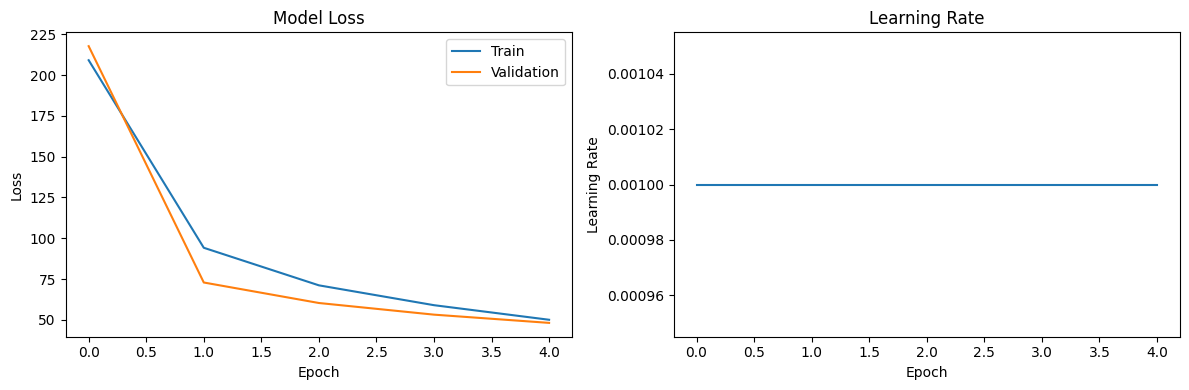

In [18]:
# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

plt.subplot(1, 2, 2)
plt.plot(history.history["learning_rate"])
plt.title("Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.tight_layout()
plt.show()


## 7. Model Evaluation and Inference

Now, let's evaluate the model and use it for inference.


In [19]:
# Load the best model weights
prediction_model.load_weights(checkpoint_path)


In [20]:
# Function to decode the predictions
def decode_predictions(pred):
    # Use greedy decoding (best path)
    pred = tf.argmax(pred, axis=-1)
    pred = tf.cast(pred, dtype=tf.int32)

    # Convert to characters
    pred = num_to_char(pred)

    # Join characters to form words
    pred = tf.strings.reduce_join(pred, axis=-1)

    return pred.numpy()


In [21]:
# Function to perform CTC beam search decoding
def decode_batch_predictions(pred):
    # Use CTC beam search decoding
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=False, beam_width=10)[0][0]

    # Convert to characters
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)

    return output_text


In [22]:
# Test the model on a few samples
test_samples = val_df.sample(5)

for _, row in test_samples.iterrows():
    # Load and preprocess audio
    audio_data, frame_rate = read_wav_file(row["wav_file"])
    spectrogram = compute_spectrogram(audio_data, frame_rate)

    # Expand dimensions for batch
    spectrogram = tf.expand_dims(spectrogram, axis=0)

    # Make prediction
    prediction = prediction_model.predict(spectrogram)

    # Decode prediction
    decoded_prediction = decode_batch_predictions(prediction)[0]

    # Print results
    print(f"Original text: {row['transcription']}")
    print(f"Predicted text: {decoded_prediction}")
    print("-" * 80)

    # Play the audio
    display(Audio(audio_data, rate=frame_rate))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
Original text: implied that Oswald's fellow employees did not like him because he was propagandizing
Predicted text: impid that oswalds fel o employes did not lykim mecase he was popagandising
--------------------------------------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
Original text: High authorities were in favor of continuous separation.
Predicted text: ha thorities were n faver of continuas seperation
--------------------------------------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Original text: when the first shock of the verdict and the solemn notification of the impending blow keeps nearly all awake, or at least disturbs their night's rest.
Predicted text: we the firs shaock of the verdit and he sola nofication of the ampending blow kheps nearly al awae or t leas disterve ther nihts rest
--------------------------------------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Original text: Confinement for twelve months in the Bristol jail was counted a punishment equivalent to seven years' transportation.
Predicted text: confinmet for t muns in the brestl jal was counted apunishment iequivelint to sn years transpotation
--------------------------------------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Original text: The promulgation of these two Jail Acts strengthened the hands of the Prison Discipline Society enormously.
Predicted text: the prougation o these to jal acts strinkin the hanse of the prison disiplancesciety andnormisly
--------------------------------------------------------------------------------
